# RPLAN

In [4]:
import os
from utils import load_pickle

# path: rplan global
# dir_rplan = r"C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\rplan\0-full"
dir_rplan = "../external_data"

# paths: image, access graph, gmn graph
img_path = os.path.join(dir_rplan, "original")
graph_path = os.path.join(dir_rplan, "poly-aag")
graph_gmn_path = os.path.join(dir_rplan, "gmn-graph")

# valid identies
ids = load_pickle(os.path.join(dir_rplan, 'valid_ids.pickle'))['full'].tolist()  # full: for full, train: for train, eval: for evaluation
print(f"Dataset size: {len(ids)}")

FileNotFoundError: [Errno 2] No such file or directory: '../external_data\\valid_ids.pickle'

Utility function for loading images as Pytorch tensors:

In [2]:
import torch
import matplotlib.pyplot as plt

def load_image(id, path):
    return torch.tensor((255*plt.imread(os.path.join(path, 'original', f'{id}.png'))[..., 1]).astype(int))

## Visualization

Plotting floor plans (w/ and w/out graphs)

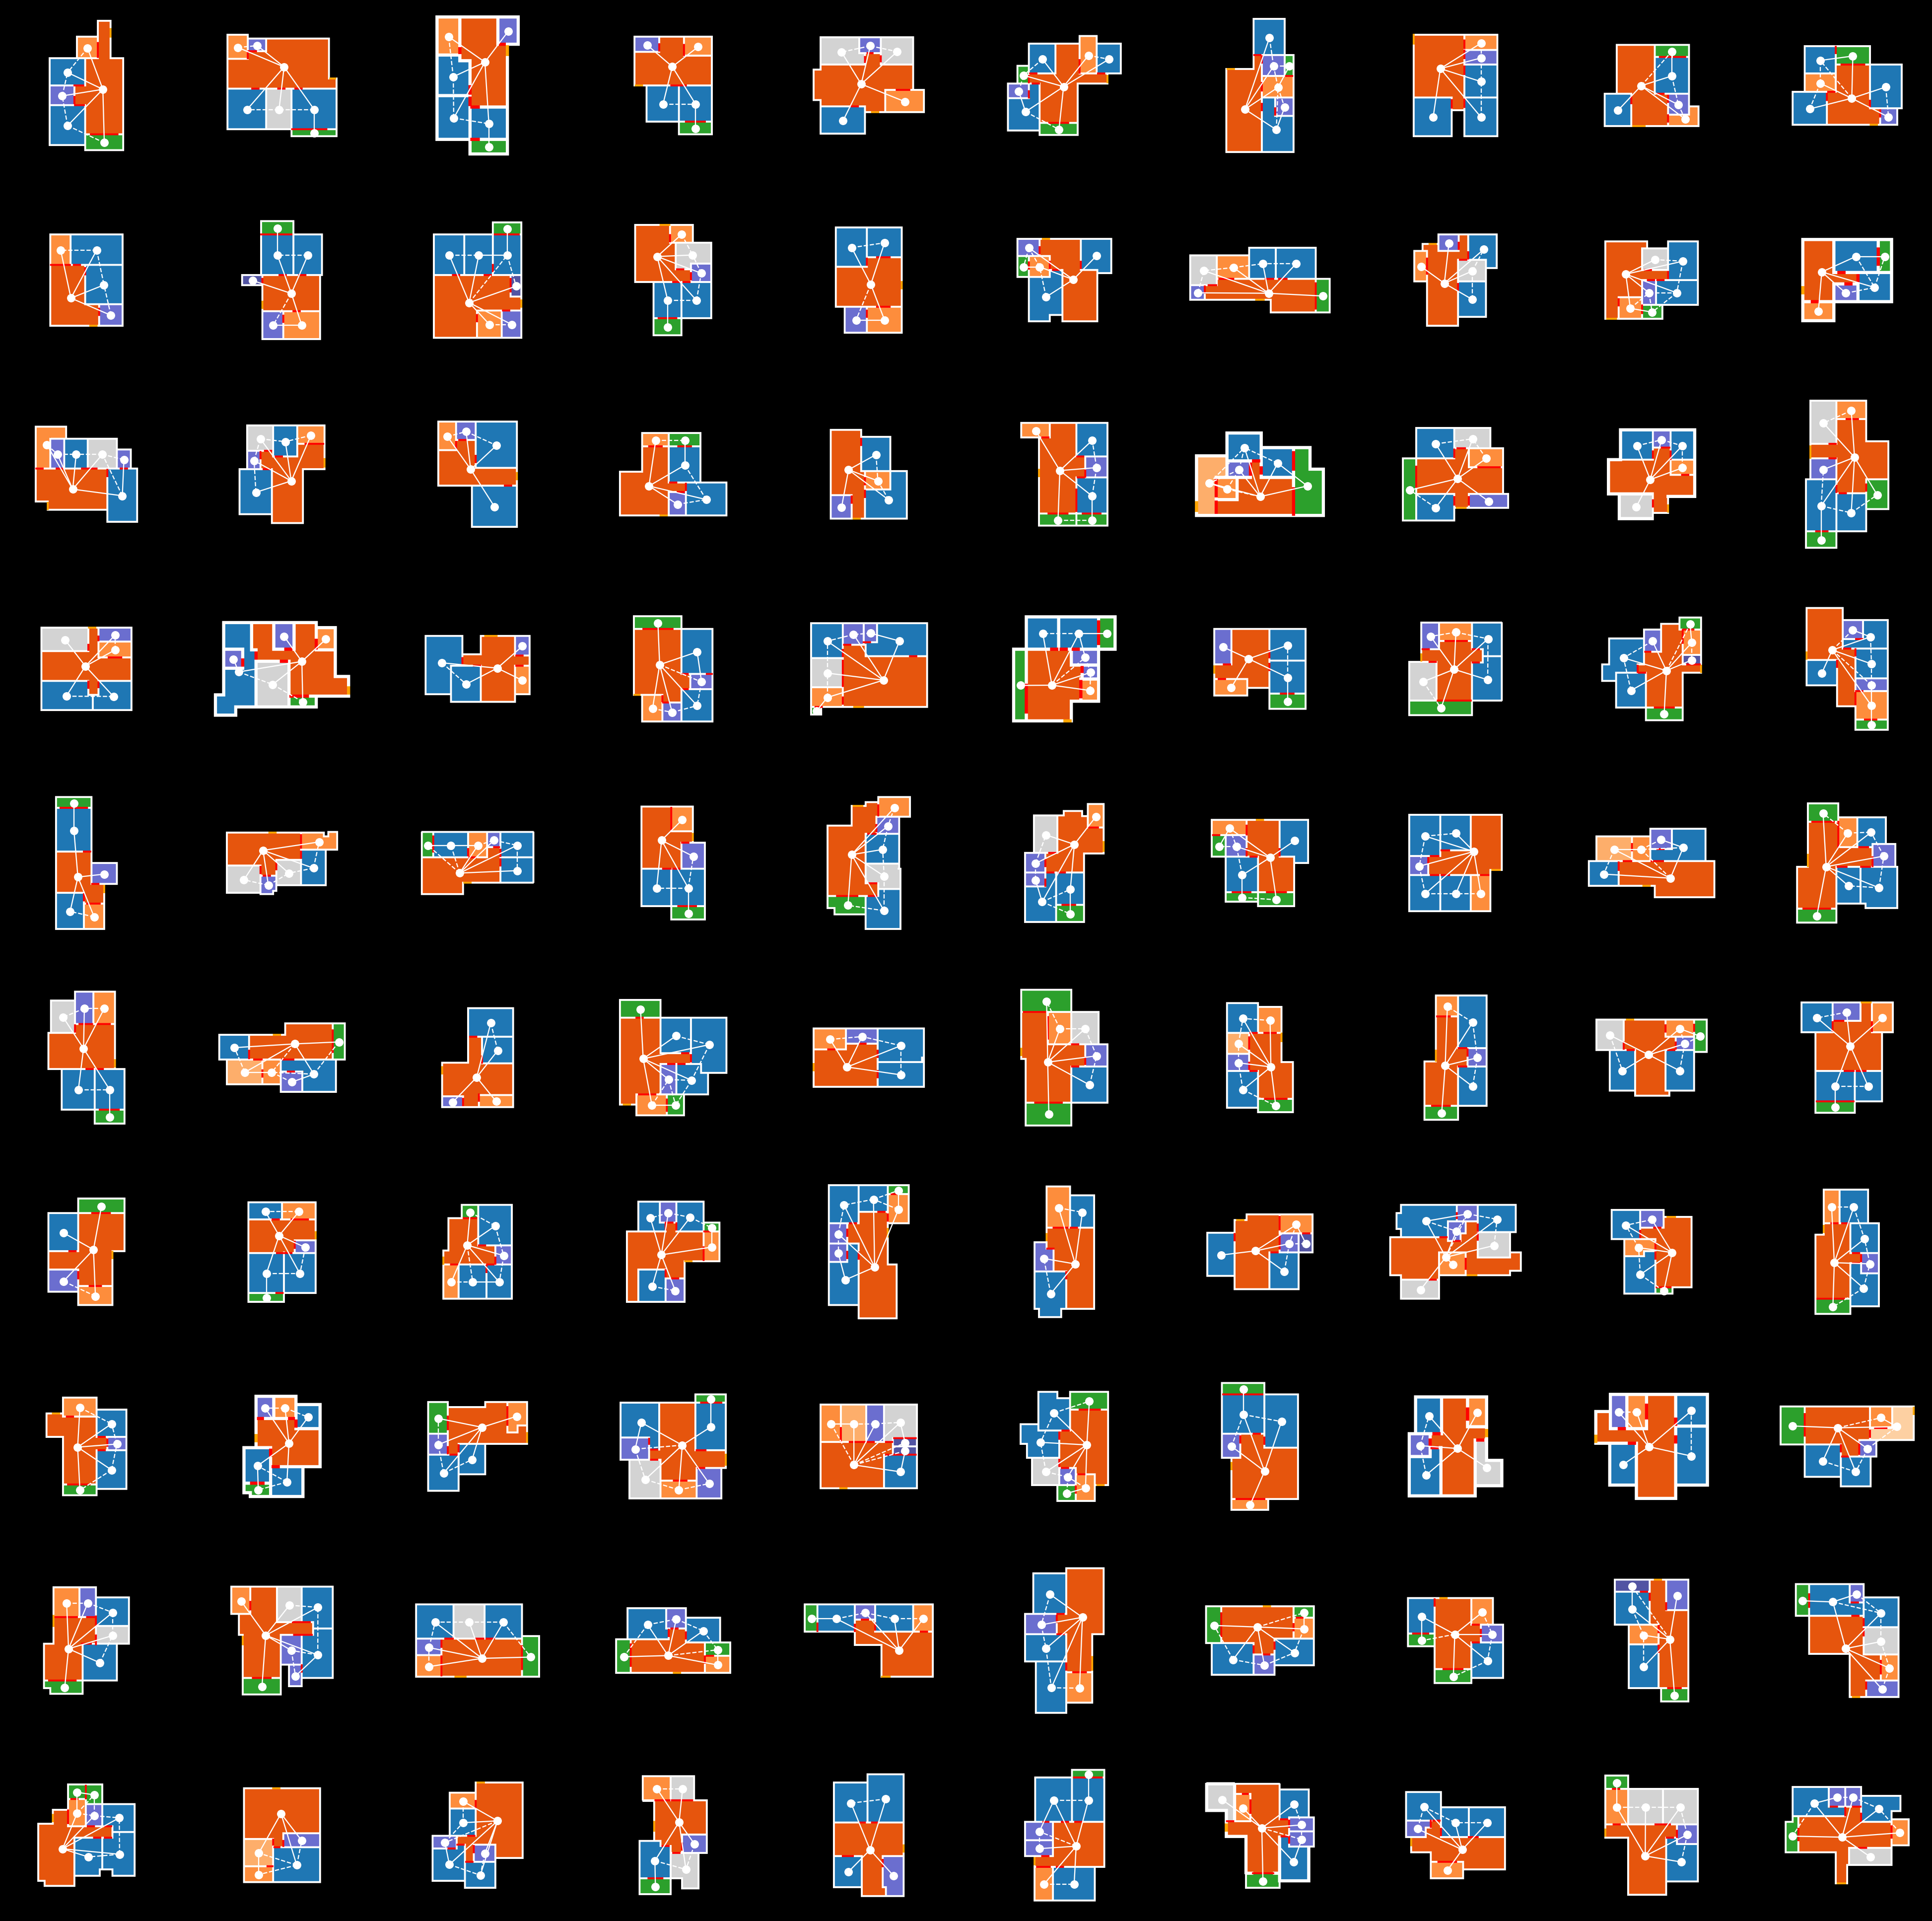

In [5]:
import numpy as np
from utils import pyg_to_nx, colorize_floorplan
from constants import CMAP_RPLAN, CLASSES_RPLAN
from plot import set_figure, plot_graph

fs = 5
n = 10
fig, axs = set_figure(n,n,fs=fs,fs_legend=2)
fig.set_facecolor('black')
cmap = CMAP_RPLAN

for i, ax in enumerate(axs):

    # get id
    id = ids[i]

    # set axis
    ax.axis('off')
    ax.set_aspect('equal')

    # get graph and attributes
    graph = torch.load(os.path.join(graph_path, f"poly-aag-{id}"))
    graph = pyg_to_nx(graph, node_attrs=["category", "centroid"], edge_attrs=["door"], graph_attrs=[])

    pos = {n: np.array(graph.nodes[n]['centroid']) for n in graph.nodes}
    categories = [label for _, label in graph.nodes("category")]
    colors = [np.array(cmap(cat)).reshape(1,4) for cat in categories]

    # get image and plot
    img = load_image(id, dir_rplan)
    img = colorize_floorplan(img, CLASSES_RPLAN, CMAP_RPLAN)

    ax.imshow(img, alpha=1)

    # plot graph
    plot_graph(graph, ax, pos=pos, c_node='white',
               dw_edge=True, c_edge=['white']*4,
               node_size=fs*25, edge_size=fs/3)


## Graph types

Two graph types:
- **Access graph**, used in floor plan generation works primilarily
- **"UI" graph**, used in deep metric learning works primilarily *eg* in LayoutGMN, GCN-CNN

**Nodes**: In both access graph and "UI" graph, the nodes correspond to the rooms. Differences:
- Access graph: polygon (shape of the room as a polygonal loop), centroid (x, y), category (integer)
- Full graph: geometric features (array), category (integer)

**Edges**:
- Access graph: edges represent semantic connections between rooms. An edge is present if and only if rooms are adjacent. Two types: adjacent only (wall in-between) and access connectivity (door in-between as well), dotted and solid lines, resp.
- "UI" graph: every pair of rooms has an edge, and has two directions. The edge features represent the inter-geometric features.

**Geometric features** (in order):
- width,
- height,
- area,
- centroid x,
- centroid y

**Inter-geometric features** (in order):
- difference in centroid x,
- ifference in centroid y,
- difference in area,
- IoU,
- width 1 / height 1,
- width 2 / height 2,
- Eucl. distance of centers,
- angle between centers

**Allocated folders**:
- Access graph: `poly-aag` (polygon-attributed access graph)
- "UI" graph: `gmn-graph` (graph matching network graph)

In [13]:
import os

from utils import pyg_to_nx
from torch_geometric.utils import from_networkx
import random

# choose one randomly
random.seed(123)
id = random.choice(ids)

# load access graph (graph) and proximity graph (graph_gmn)
graph_pyg = torch.load(os.path.join(graph_path, f'poly-aag-{id}'))
graph_nx = pyg_to_nx(graph_pyg, node_attrs=['polygon', 'category', 'centroid'], edge_attrs=['door'], graph_attrs=[])
graph_gmn_nx = torch.load(os.path.join(graph_gmn_path, f'{id}'))
graph_gmn_pyg = from_networkx(graph_gmn_nx)

# print graphs (pyg)
print(graph_pyg)
print(graph_gmn_pyg)

Data(edge_index=[2, 22], polygon=[7], category=[7], centroid=[7, 2], door=[22], num_nodes=7)
Data(edge_index=[2, 42], geometry=[7, 5], category=[7], inter-geometry=[42, 8], num_nodes=7)


Geometry characteristics of the nodes:
	 X-center   Y-center   X-width    Y-height   Area
	[0.59960938 0.50390625 0.28125    0.48046875 0.13513184]
	[0.4296875  0.73242188 0.19921875 0.21875    0.0435791 ]
	[0.59570312 0.23828125 0.1328125  0.15234375 0.02023315]
	[0.48046875 0.328125   0.09765625 0.16015625 0.01564026]
	[0.36132812 0.3828125  0.1953125  0.18359375 0.03585815]
	[0.36132812 0.54882812 0.1953125  0.1484375  0.0289917 ]
	[0.63476562 0.79296875 0.2109375  0.09765625 0.02059937]


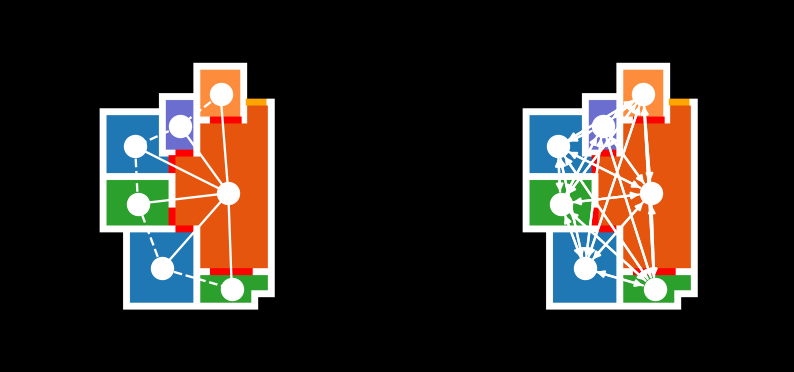

In [17]:
# print geometry values
print(f"Geometry characteristics of the nodes:\n\t X-center   Y-center   X-width    Y-height   Area")
for n in graph_gmn_nx.nodes(data='geometry'):
    print(f"\t{np.array(n[1])}")

# figure settings
fs = 5
fig, axs = set_figure(1, 2, fs=fs)
fig.set_facecolor('black')

pos = {n: np.array(graph_nx.nodes[n]['centroid']) for n in graph_nx.nodes}
colors = [np.array(cmap(n)).reshape(1,4) for _, n in graph_nx.nodes('category')]

# access graph (sparsely connected)
plot_graph(graph_nx, axs[0],
           pos = pos,
           c_node="white",
           dw_edge=True, c_edge=['white']*4,
           node_size=fs*50, edge_size=fs/3)
# proximity graph (fully connected)
plot_graph(graph_gmn_nx, axs[1],
           pos = pos,
           c_node="white",
           dw_edge=False, c_edge=['white']*4,
           node_size=fs*50, edge_size=fs/3)

# load; colorize; and plot the image as well
for ax in axs:
    img_ = (255*plt.imread(os.path.join(img_path, f'{id}.png'))[..., 1]).astype(int)
    img = colorize_floorplan(img_, classes=CLASSES_RPLAN, cmap=CMAP_RPLAN)

    ax.imshow(img)  # alpha for transparency (lower is more transparent)
    # ax.set_title(id)

### Pairs / triplets for deep metric learning

In [19]:
import networkx as nx
import torch_geometric as pyg

class Triplet_Dataset_RPLAN(torch.utils.data.Dataset):

    """
    Geometry Triplet Graph Dataset for RPLAN.

    Generates a graph pair as a single Data() object.
    edge_index:
        room_i to room_j: all combinations, except i == j, should be in there.
        (NOT THE CASE ANYMORE; FOR MSD ONLY ACCESS CONNECTED NODES ARE IN THERE!)
    node_features:
        'geometry': geometric features of rooms (based on bounding boxes)
        'order': whether graph 0 or 1, such that the graph matching network knows which to match
    edge_features:
        'inter-geometry': inter-geometric features between rooms (based on 'difference' in bounding boxes).
            Note: this is not symmetrical. Therefore, the geometry graph is a directed graph.
    """

    def __init__(self,
                 dir_rplan,
                 graph_path='gmn-graph',
                 triplet_path='triplets_iou_74K.pickle',
                 shuffle=True,
                 mode='train'):

        self.graph_path = os.path.join(dir_rplan, graph_path)
        self.triplets = load_pickle(os.path.join(dir_rplan, f'{mode}_{triplet_path}'))
        if shuffle: random.shuffle(self.triplets)
        # self.image_transform = image_transform
        # self.graph_transform = graph_transform

    def __getitem__(self, index):
        # TODO: graph transformations (??)

        # get identity pairs (saved as tuples of two integers)
        triplet = self.triplets[index]

        # get graphs (saved as networkx DiGraph() objects)
        # also: add order index ("0" for graph 1; "1" for graph 2)
        graphs = []
        for i, id in enumerate(triplet):  # actually a 4-tuple: [a, p, a, n]
            graph = torch.load(os.path.join(self.graph_path, f'{id}'))
            graph.add_nodes_from([[n, {'order': i, 'id': id}] for n in graph.nodes()])
            graphs.append(graph)

        # make large disconnected graph through unification of the two graphs
        graph_triplet = nx.disjoint_union_all(graphs)

        # make pytorch geometric graph
        graph_triplet = pyg.utils.from_networkx(graph_triplet)

        return graph_triplet

    def __len__(self):
        return len(self.triplets)

In [21]:
from torch_geometric.loader import DataLoader

bs = 4
dataset = Triplet_Dataset_RPLAN(dir_rplan)
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

In [22]:
from utils import pyg_to_nx

data_batch = next(iter(dataloader))
data_batch_nx = pyg_to_nx(data_batch, node_attrs=['category', 'geometry', 'batch', 'order', 'id'], edge_attrs=['inter-geometry'], graph_attrs=['id'])
print(data_batch)

DataBatch(edge_index=[2, 582], geometry=[103, 5], category=[103], order=[103], id=[103], inter-geometry=[582, 8], num_nodes=103, batch=[103], ptr=[5])


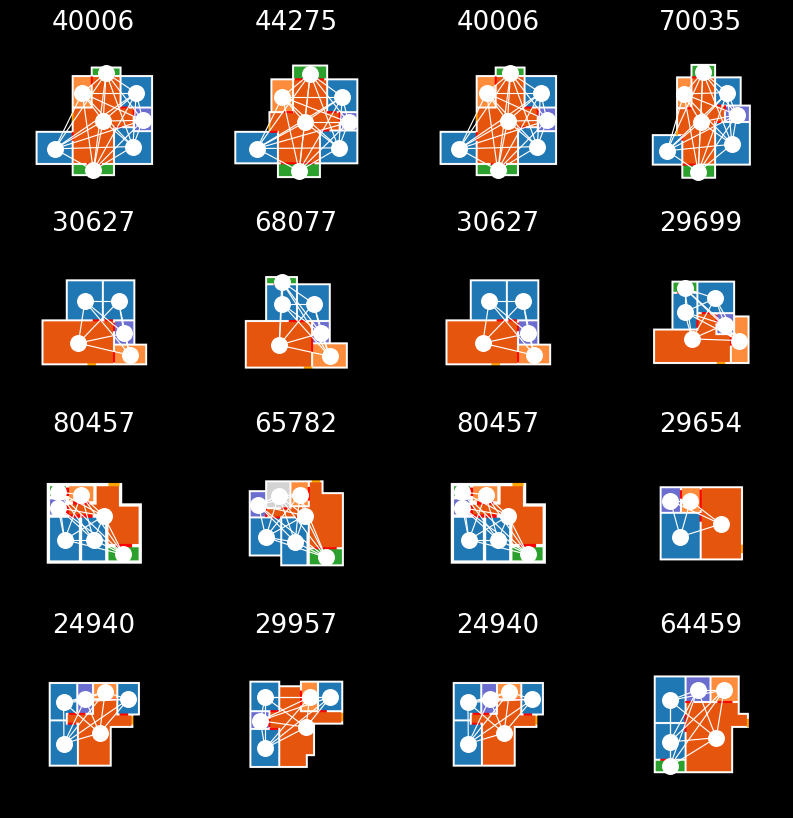

In [25]:
fs = 2.5
fig, axs = set_figure(4, bs, fs=fs)
fig.set_facecolor('black')

for i, ax in enumerate(axs):

    batch_id = int(np.floor(i / 4))
    order_id = i % 4

    # get graph
    nodes = [n for n, d in data_batch_nx.nodes(data=True)
             if (d['order'] == order_id) * (d['batch'] == batch_id)]

    # get subgraph
    graph = data_batch_nx.subgraph(nodes)
    id = list(graph.nodes('id'))[0][1]

    # plot graph
    pos = {n: np.array(graph.nodes[n]['geometry'][:2]) * 256 for n in graph.nodes}
    colors = [np.array(cmap(c)).reshape(1,4) for _, c in graph.nodes('category')]

    # proximity graph (fully connected)
    plot_graph(graph, ax,
               pos=pos, c_node='white',
               dw_edge=False, c_edge=['white']*4,
               node_size=fs*50, edge_size=fs/3)

    # plot corresponding image
    img = (255*plt.imread(os.path.join(img_path, f'{id}.png'))[..., 1]).astype(int)
    img = colorize_floorplan(img, classes=CLASSES_RPLAN, cmap=CMAP_RPLAN)

    ax.imshow(img)  # alpha for transparency (lower is more transparent)
    ax.set_title(id, color = 'white')